In [1]:
import torch
import matplotlib.pyplot as plt

from vaes import AE, VAE, PoissonVAE, PredictiveAE, PredictiveVAE
from train import train
from mnist import MNIST
from evaluate import evaluate, knn_analysis


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

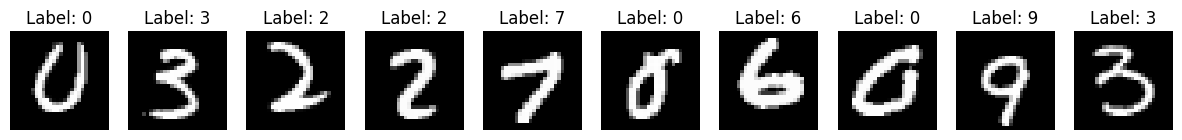

Train dataset shape: torch.Size([48000, 1, 28, 28])
Val dataset shape: torch.Size([12000, 1, 28, 28])
Range: [-0.424, 2.821]
Mean & std: [0.000, 1.000]
Device & dtype: cuda:0, torch.float32


In [3]:
VAL_RATIO = 0.2
dataset_device = device
# dataset_device = torch.device('cpu') # Uncomment if dataset cannot fit on device (this is compatable with GPU training)
train_dataset = MNIST(root='../../datasets/', train=True, device=dataset_device, normalize=True)
val_dataset = train_dataset.get_val_dataset(VAL_RATIO, shuffle=True)
test_dataset = MNIST(root='../../datasets/', train=False, device=dataset_device, normalize=True)

# Show example images
fig, axes = plt.subplots(1, 10, figsize=(15,5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu().to(torch.float32), cmap='gray')
    ax.set_title(f"Label: {label}")
    ax.axis('off')
plt.show()

print(f'Train dataset shape: {train_dataset.images.shape}')
print(f'Val dataset shape: {val_dataset.images.shape}')
print(f'Range: [{train_dataset.images.min().item():.3f}, {train_dataset.images.max().item():.3f}]')
print(f'Mean & std: [{train_dataset.images.mean().item():.3f}, {train_dataset.images.std().item():.3f}]')
print(f'Device & dtype: {train_dataset.images.device}, {train_dataset.images.dtype}')

In [4]:
torch.manual_seed(42)

cnn = True
models = {
    # 'PredictiveVAE': PredictiveVAE(cnn=cnn).to(device),
    'AE': AE(cnn=cnn).to(device),
    # 'PredictiveAE': PredictiveAE(cnn=cnn).to(device),
    'VAE': VAE(cnn=cnn).to(device),
    # 'PoissonVAE': PoissonVAE(cnn=cnn).to(device)
}

train_logs = {}
eval_logs = {}
for i, (model_name, model) in enumerate(models.items()):
    print(f'{i+1}/{len(models)}: Training {model_name}...')
    train_logs[model_name] = train(model, train_dataset, val_dataset)
    eval_logs[model_name] = evaluate(model, test_dataset)

1/2: Training AE...


2/2: Training VAE...


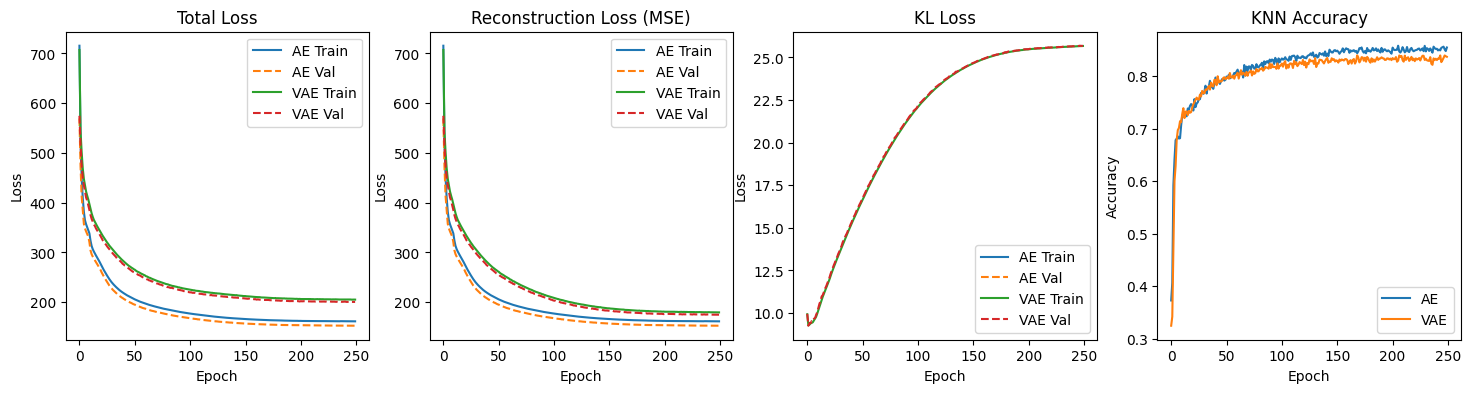

AE: ([0.855641864268193, 0.9103517364203029, 0.9345104333868377])
VAE: ([0.8447465249386754, 0.915093499554764, 0.9435794542536116])


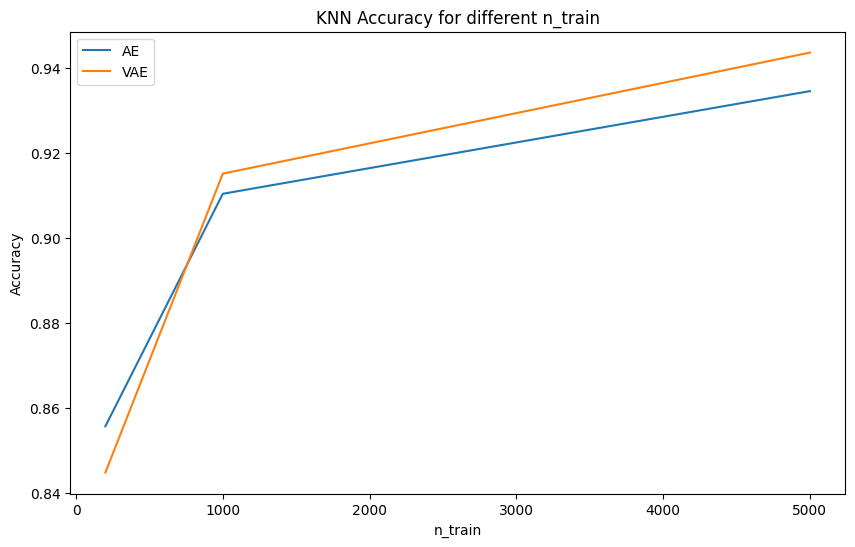

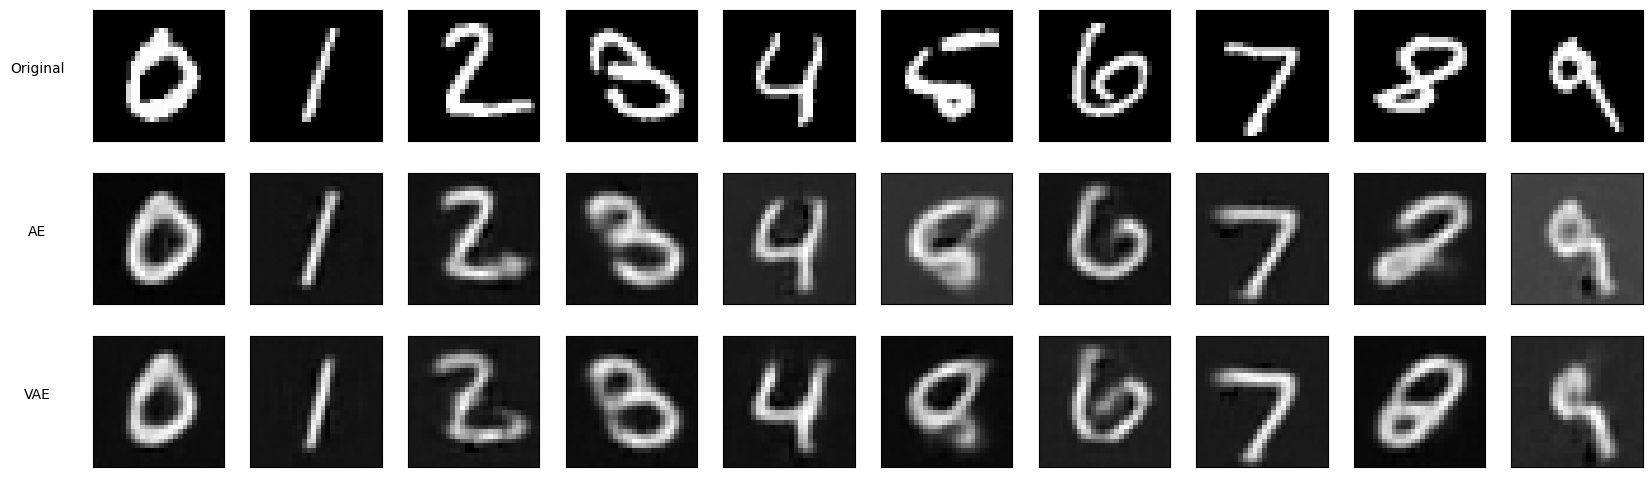

AE: best val acc: 0.860 - recon
VAE: best val acc: 0.842 - recon


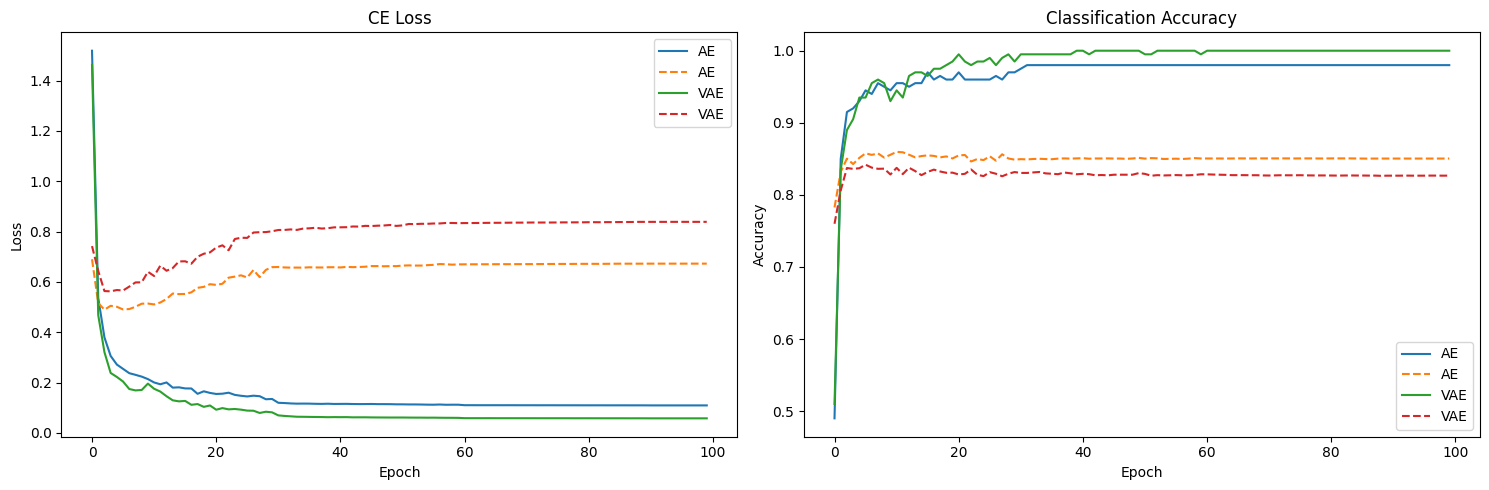

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

# =========== Training Metrics ===========

for model_name, log in train_logs.items():
    axes[0].plot(log['train_losses'], label=f'{model_name} Train')
    axes[0].plot(log['val_losses'], label=f'{model_name} Val', linestyle='--')
    axes[1].plot(log['train_recon_losses'], label=f'{model_name} Train')
    axes[1].plot(log['val_recon_losses'], label=f'{model_name} Val', linestyle='--')
    if 'train_kl_losses' in log:
        axes[2].plot(log['train_kl_losses'], label=f'{model_name} Train')
        axes[2].plot(log['val_kl_losses'], label=f'{model_name} Val', linestyle='--')
    axes[3].plot(log['knn_acc'], label=f'{model_name}')
axes[0].set_title('Total Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Reconstruction Loss (MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

axes[2].set_title('KL Loss')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()

axes[3].set_title('KNN Accuracy')
axes[3].set_xlabel('Epoch')
axes[3].set_ylabel('Accuracy')
axes[3].legend()

plt.show()

# =========== Evaluation Metrics ===========
sizes = [200, 1000, 5000]

knn_accs = {}
for model_name in models.keys():
    for n_train in sizes:
        knn_accs[model_name, n_train] = knn_analysis(models[model_name], test_dataset, n_train=n_train)
    print(f'{model_name}: ({[knn_accs[model_name, n] for n in sizes]})')

# Plot KNN Accuracy for different n_train
fig, ax = plt.subplots(figsize=(10, 6))
for model_name in models.keys():
    y = [knn_accs[model_name, n] for n in sizes]
    ax.plot(sizes, y, label=model_name)

ax.set_title('KNN Accuracy for different n_train')
ax.set_xlabel('n_train')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()


# =========== Reconstruction ===========

# Collect 1 image per class
original = []
for i in range(10):
    indices = torch.where(test_dataset.targets == i)[0]
    original.append(test_dataset[indices[0]][0])
images = {'Original': torch.stack(original)}

# Reconstruct images
for model_name, model in models.items():
    with torch.no_grad():
        x_hat = model(images['Original'].to(device))[0]
    images[model_name] = x_hat.view(10, 1, 28, 28)


# Plot images
fig, axs = plt.subplots(len(images), 10, figsize=(20, 6))
for i in range(10):
    for j, model_name in enumerate(images.keys()):
        axs[j, i].imshow(images[model_name][i].cpu().numpy().squeeze(), cmap='gray')
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Label each row
for j, model_name in enumerate(images.keys()):
    axs[j, 0].set_ylabel(model_name, rotation=0, labelpad=40)
plt.show()

# =========== Linear Probing ===========

# Plot evaluation logs for each model
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes = axes.flatten()

for model_name, eval_log in eval_logs.items():
    print(f'{model_name}: best val acc: {max(eval_log["val_accs"]):.3f} - recon')
    axes[0].plot(eval_log['train_losses'], label=f'{model_name}')
    axes[0].plot(eval_log['val_losses'], label=f'{model_name}', linestyle='--')
    axes[1].plot(eval_log['train_accs'], label=f'{model_name}')
    axes[1].plot(eval_log['val_accs'], label=f'{model_name}', linestyle='--')

axes[0].set_title('CE Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Classification Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()


plt.tight_layout()
plt.show()

In [7]:
fashion_dataset = MNIST(root='../../datasets/', train=False, device=dataset_device, normalize=False, fashion=True)
# Collect 1 image per class
original = []
for i in range(10):
    indices = torch.where(fashion_dataset.targets == i)[0]
    original.append(fashion_dataset[indices[0]][0])
images = {'Original': torch.stack(original)}

# Reconstruct images
for model_name, model in models.items():
    with torch.no_grad():
        x_hat = model(images['Original'].to(device))[0]
    images[model_name] = x_hat.view(10, 1, 28, 28)

# Plot images
fig, axs = plt.subplots(4, 10, figsize=(20, 6))
for i in range(10):
    for j, model_name in enumerate(images.keys()):
        axs[j, i].imshow(images[model_name][i].cpu().numpy().squeeze(), cmap='gray')
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Label each row
axs[0, 0].set_ylabel('original', rotation=0, labelpad=40)
axs[1, 0].set_ylabel('AE', rotation=0, labelpad=40)
axs[2, 0].set_ylabel('VAE', rotation=0, labelpad=40)
axs[3, 0].set_ylabel('PoissonVAE', rotation=0, labelpad=40)

plt.show()

TypeError: 'NoneType' object is not callable